# Ovarian cancer logistic regression using ADVI

In [38]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from tqdm import tqdm

from pathlib import Path
from random import choices



In [2]:

import tensorflow as tf
import tensorflow_probability as tfp

from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-02-08 04:05:14.566042: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 04:05:14.607597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 04:05:14.607641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 04:05:14.609224: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 04:05:14.616369: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 04:05:14.616802: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
print(tf.__version__, tfp.__version__)

2.15.0 0.23.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [4]:
from ucimlrepo import fetch_ucirepo 


In [5]:
dataset = "ovarian"
# dataset = "breast"
use_saved = False

if dataset == "breast":
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

    # data (as pandas dataframes) 
    batch_size=151
    X_ = cdc_diabetes_health_indicators.data.features
    y_ = cdc_diabetes_health_indicators.data.targets

    X_ = X_.fillna(0)
    batch_size=300
    
else:
    X_ = pd.read_csv(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overianx.csv", header=None)
    y_ = pd.read_table(Path.home() / "workspace" / "bayesianquilts"/ "bayesianquilts"/ "data" / "overiany.csv", header=None)
    batch_size = 6

X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(54, 1536)


In [6]:
ndx = np.abs(X_scaled).sum(axis=1).sort_values(ascending=False)[:10].index

In [7]:
X_scaled = pd.concat([X_scaled.loc[ndx, :]*5, X_scaled], axis=0)
y_ = pd.concat([ 1-y_.loc[ndx, :], y_], axis=0)

In [8]:
X_scaled = (X_scaled - X_scaled.mean())/X_scaled.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(64, 1536)


In [9]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [11]:
if not use_saved:

    lr_model = LogisticRegression2(dim_regressors=p)

        
else:
    import dill as pickle
    import gzip
    if dataset == 'ovarian':
        with gzip.open("ovarian_gwas.gz", 'rb') as f:
            lr_model = pickle.load(f)
    else:
        with gzip.open("breast.gz", 'rb') as f:
            lr_model = pickle.load(f)

Set up Bayesian minibatch ADVI inference

In [17]:

losses = lr_model.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=n,
    batches_per_step=9,
    check_every=int(n/batch_size)*50,
    batch_size=batch_size,
    num_steps=10000,
    max_decay_steps=10,
    max_plateau_epochs=100,
    sample_size=36,
    learning_rate=0.0005,
    lr_decay_factor=0.9
    )



Running optimization for 10000 steps of 9 accumulated batches, checking every 500 steps
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-1


  5%|▍         | 499/10000 [00:36<10:56, 14.47it/s]

Step 500: average-batch loss:3581.3381670766335 rel loss: 2.7922523742466848e+304
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-2


 10%|▉         | 999/10000 [01:10<10:27, 14.35it/s]

Step 1000: average-batch loss:3578.5058073813834 rel loss: 0.0007914922729502704
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-3


 15%|█▍        | 1499/10000 [01:45<09:50, 14.40it/s]

Step 1500: average-batch loss:3576.307923946908 rel loss: 0.0006145677277279303
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-4


 20%|█▉        | 1999/10000 [02:20<09:14, 14.42it/s]

Step 2000: average-batch loss:3573.22980831361 rel loss: 0.0008614379142746782
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-5


 25%|██▍       | 2499/10000 [02:55<08:42, 14.37it/s]

Step 2500: average-batch loss:3571.46258779659 rel loss: 0.0004948170318397378
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-6


 30%|██▉       | 2999/10000 [03:30<08:07, 14.36it/s]

Step 3000: average-batch loss:3568.6032763107255 rel loss: 0.0008012410639325837
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-7


 35%|███▍      | 3499/10000 [04:05<07:34, 14.32it/s]

Step 3500: average-batch loss:3567.219749289992 rel loss: 0.00038784462914264866
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-8


 40%|███▉      | 3999/10000 [04:39<06:56, 14.40it/s]

Step 4000: average-batch loss:3564.3524676542675 rel loss: 0.0008044326877726891
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-9


 45%|████▍     | 4499/10000 [05:14<06:25, 14.27it/s]

Step 4500: average-batch loss:3562.222523211773 rel loss: 0.0005979257131230624
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-10


 50%|████▉     | 4999/10000 [05:49<05:46, 14.43it/s]

Step 5000: average-batch loss:3559.633670809386 rel loss: 0.0007272805692386026
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-11


 55%|█████▍    | 5499/10000 [06:24<05:13, 14.37it/s]

Step 5500: average-batch loss:3557.2511212570885 rel loss: 0.0006697726618342991
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-12


 60%|█████▉    | 5999/10000 [06:59<04:38, 14.35it/s]

Step 6000: average-batch loss:3556.221171575167 rel loss: 0.0002896191300344261
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-13


 65%|██████▍   | 6499/10000 [07:34<04:05, 14.25it/s]

Step 6500: average-batch loss:3552.6890060717215 rel loss: 0.000994223107457131
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-14


 70%|██████▉   | 6999/10000 [08:08<03:29, 14.33it/s]

Step 7000: average-batch loss:3551.2164369603465 rel loss: 0.0004146661116029765
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-15


 75%|███████▍  | 7499/10000 [08:43<02:52, 14.47it/s]

Step 7500: average-batch loss:3549.555731319362 rel loss: 0.0004678629571388868
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-16


 80%|███████▉  | 7999/10000 [09:18<02:19, 14.35it/s]

Step 8000: average-batch loss:3546.708392519455 rel loss: 0.0008028116452743792
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-17


 85%|████████▍ | 8499/10000 [09:53<01:44, 14.38it/s]

Step 8500: average-batch loss:3545.4875706919856 rel loss: 0.00034433115421450013
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-18


 90%|████████▉ | 8999/10000 [10:28<01:09, 14.48it/s]

Step 9000: average-batch loss:3543.645200379624 rel loss: 0.0005199082323942417
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-19


 95%|█████████▍| 9499/10000 [11:02<00:34, 14.40it/s]

Step 9500: average-batch loss:3543.1722679848485 rel loss: 0.00013347711006001265
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-20


100%|█████████▉| 9999/10000 [11:37<00:00, 14.43it/s]

Step 10000: average-batch loss:3540.648449771632 rel loss: 0.0007128124265992529
Saved a checkpoint: /tmp/tfcheckpoints/28a557e8-7792-434e-8584-ea61af1991f9/28a557e8-7792-434e-8584-ea61af1991f9-21


Terminating because we are out of iterations


100%|██████████| 10000/10000 [11:37<00:00, 14.33it/s]







11it [00:00, 19.57it/s]


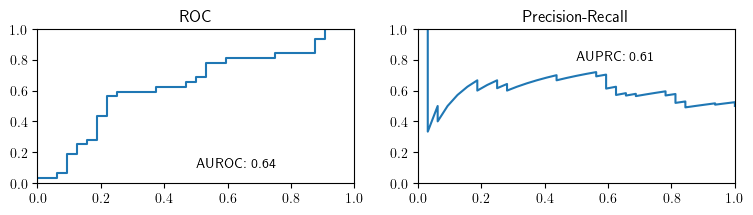

In [39]:
def prediction_fn(data):
    params = lr_model.sample(128)
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig("roccurve.pdf", bbox_inches='tight')

In [31]:
if dataset == "ovarian":
    batch = next(iter(data_factory_factory(batch_size=56)()))
else:
    batch = next(iter(data_factory_factory()()))
params = lr_model.sample(128)


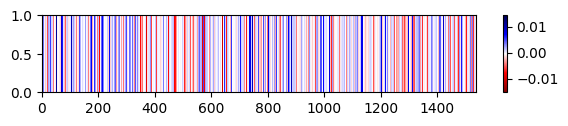

In [32]:
beta = tf.reduce_mean(params['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, cmap='seismic_r')
plt.colorbar(im)

In [35]:
h_vals = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
loo_khat = {}
reduced_ndx = {}
high_khat_ndx = {}
n_sample = [128]
records = []
for n_samples in n_sample:
    sample_ndx = choices(range(2000), k=n_samples)
    reduced_ndx[n_samples] = []
    high_khat_ndx[n_samples] = {}
    print(f"Samples: {n_samples}")
    loo_khat[n_samples] = {}
    params = fit.stan_variables()

    params['c'] = params['c'][:, tf.newaxis]
    params['tau'] = params['tau'][:, tf.newaxis]
    params['caux'] = params['caux'][:, tf.newaxis]
    params['beta0'] = params['beta0'][:, tf.newaxis]
    params = {k: v[sample_ndx] for k, v in params.items()}
    


    for h in h_vals:
        loo_khat[n_samples][h] = {}
        loo = adaptive_is_loo(lr_model, batch, params, h, variational=False)
        khat = pd.DataFrame({"khat": loo["I"]['khat']})
        khat = khat.loc[khat.khat> 0.7] 
        ndx = np.array(khat.index)
        high_khat_ndx[n_samples][h] = np.where((loo['I']['khat']>0.7))
        print(f"rho={h}\n")
        for T in ["I", "LL", "KL", "Var"]:
            loo_khat[n_samples][h][T] = np.array(loo[T]['khat'])
            
            records += [
                {
                    "h": h,
                    "T": T,
                    "S": n_samples,
                    "khat": loo[T]['khat'],
                    "khat_high": loo[T]['khat'][ndx],
                    "p_psis": loo[T]['p_psis'].numpy(),
                    "khat>0.7": np.where((loo['I']['khat']>0.7))[0],
                    "n>0.7": (np.where((loo['I']['khat']>0.7))[0]).shape
                }
            ]
            # print(f"Transform: {T}")
            #print(
            #    f"V: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} S: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
            #)
            #print(f"k-hat reduction for these k-hat>0.7 obs: {np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7))}")
            reduced_ndx[n_samples] += [np.where((loo['I']['khat'] - loo[T]['khat']>0) * (loo['I']['khat']>0.7) * (loo[T]['khat']<0.7))]
            #print(f"k-hat reduction to below 0.7 for these k-hat>0.7 obs: {reduced_ndx[n_samples][-1]}")
            
for n_samples in n_sample:
    high_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in high_khat_ndx[n_samples].values()]))
    reduced_ndx_ = (chain.from_iterable([x[0].flatten().tolist() for x in reduced_ndx[n_samples]]))
    high_ndx_ = set(high_ndx_)
    reduced_ndx_ = set(reduced_ndx_)
    print(len(high_ndx_), len(reduced_ndx_))
        

Samples: 128


NameError: name 'fit' is not defined

In [32]:

loo = adaptive_is_loo(lr_model, batch, params, .2, variational=True)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

NameError: name 'batch' is not defined

In [33]:
loo["I"]['khat'] - loo['KL']['khat']

NameError: name 'loo' is not defined

# Compute LOO AU ROC/PRC

In [25]:
step_size = 0.2
def prediction_fn_stepaway(data):
    params = lr_model.sample(100)
    loo = adaptive_is_loo(lr_model, data, params, step_size)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    params = lr_model.sample(100)
    pred = adaptive_is_loo(lr_model, data, params, step_size)["I"]['p_loo']
    return pred



In [ ]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(batch_size=2000),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



Step-away LOO

NameError: name 'bench_stepaway_loo' is not defined

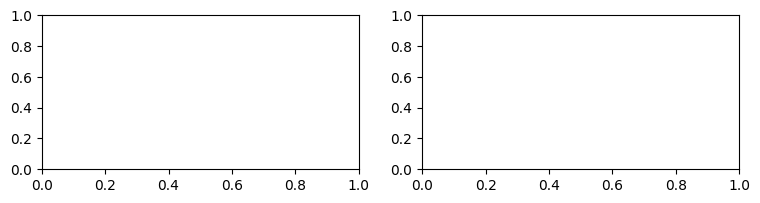

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

LOO w/o stepaway

NameError: name 'bench_loo' is not defined

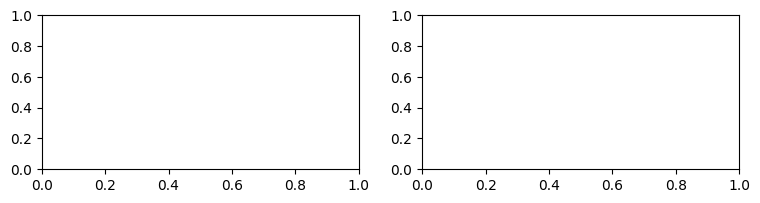

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))
_ = plt.savefig("roc_curves.pdf")

Training data metrics

In [28]:
bench['auroc']['auroc']

0.6630859375

In [22]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(batch_size=1000, repeat=False)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=True)]

0it [00:00, ?it/s]

1it [00:01,  1.40s/it]


In [23]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [24]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

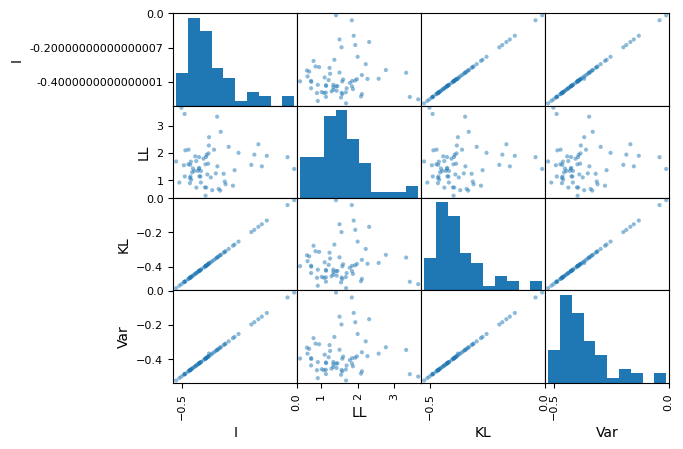

In [26]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


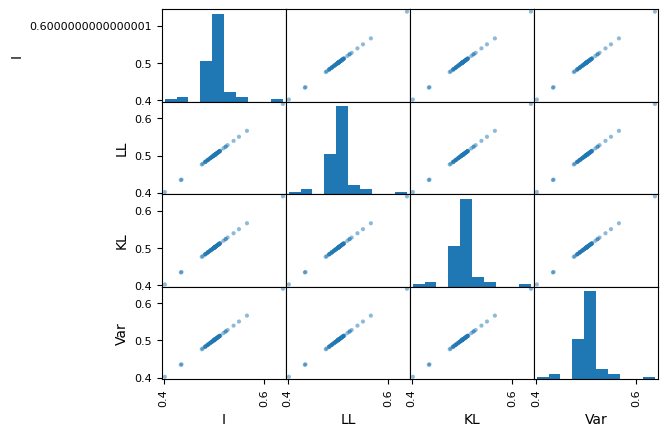

In [27]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [28]:
khat.describe()

,I,LL,KL,Var
count,64.000000,64.000000,64.000000,64.000000
mean,-0.376368,1.542146,-0.376311,-0.376151
std,0.109366,0.668750,0.109364,0.109368
min,-0.526238,0.417989,-0.526238,-0.526238
25%,-0.453600,1.116624,-0.453600,-0.453600
50%,-0.397998,1.472764,-0.397998,-0.397998
75%,-0.338923,1.875054,-0.338923,-0.338923
max,-0.011068,3.663036,-0.011068,-0.011068


In [29]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [30]:
(khat>0.5).describe()

,I,LL,KL,Var
count,64,64,64,64
unique,1,2,1,1
top,False,True,False,False
freq,64,63,64,64
